# Preliminary EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'
DATA_DIR = BASE_DIR + '/data'

DATASET = '/processed/user_song_balanced'
TRAIN_DIR = DATA_DIR + DATASET + '/train'
TEST_DIR = DATA_DIR + DATASET + '/test'

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, count, desc, min, max, log, abs, mean, stddev, row_number, rand
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils.data_loader import load_file_from_hdfs

from EDA.clean_data import cleaned_df

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.driver.host', '6f6ec6ea2650')
('spark.driver.port', '44727')
('spark.master', 'local[4]')
('spark.executor.id', 'driver')
('spark.app.id', 'local-1717100914111')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHan

Load choosen partition of song ratings, song attributes, and genre hierarchy.

In [5]:
song_ratings_train_file_path = "/raw/train/train_2.txt"
song_ratings_train = load_file_from_hdfs(song_ratings_train_file_path)

song_ratings_test_file_path = "/raw/test/test_2.txt"
song_ratings_test = load_file_from_hdfs(song_ratings_test_file_path)

song_ratings = song_ratings_train.union(song_ratings_test) # combine the train and test partition

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path)

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)

Call cleaned_df function to get cleaned df from EDA

In [6]:
df = cleaned_df(song_ratings, song_attributes, genre_hierarchy)

root
 |-- user_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- album_id: integer (nullable = true)
 |-- artist_id: integer (nullable = true)
 |-- genre_id: integer (nullable = true)
 |-- genre_name: string (nullable = true)



+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|           user_id|          song_id|            rating|          album_id|         artist_id|          genre_id|       genre_name|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          78909821|         78909821|          78909821|          78909821|          78909821|          78909821|         78909821|
|   mean|499746.46840439545|68274.02707812504|3.1528440674070213|10361.592222392697|4776.0641216636395|16.666298850177345|             NULL|
| stddev| 57936.75037674207|39459.18779033151|1.6030326088607252| 5906.090895444379| 2680.786813237493| 42.91624825455018|             NULL|
|    min|            400000|                0|                 1|                 0|                 0|                 0|Adult Alternative|
|    max|    

Null Columns in cleaned df: {'user_id': 0, 'song_id': 0, 'rating': 0, 'album_id': 0, 'artist_id': 0, 'genre_id': 0, 'genre_name': 0}


In [7]:
df.count()

78909821

Get users' rating count to ensure balanced distribution of ratings per user.

In [8]:
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show()

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
| 400003|          266|
| 400129|           60|
| 400152|          108|
| 400301|          375|
| 400440|           36|
| 400612|           67|
| 400735|          312|
| 400797|          161|
| 400833|           69|
| 400982|          687|
| 401161|           38|
| 401778|           43|
| 401880|          403|
| 401901|          678|
| 402253|          161|
| 402643|         2183|
| 402896|          140|
| 403340|         7576|
| 403389|         1021|
| 403422|           33|
+-------+-------------+
only showing top 20 rows



Min and max values of users are quite different. There must be some outliers.

In [9]:
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 30
Maximum value: 131533


Distribution is extremely skewed.

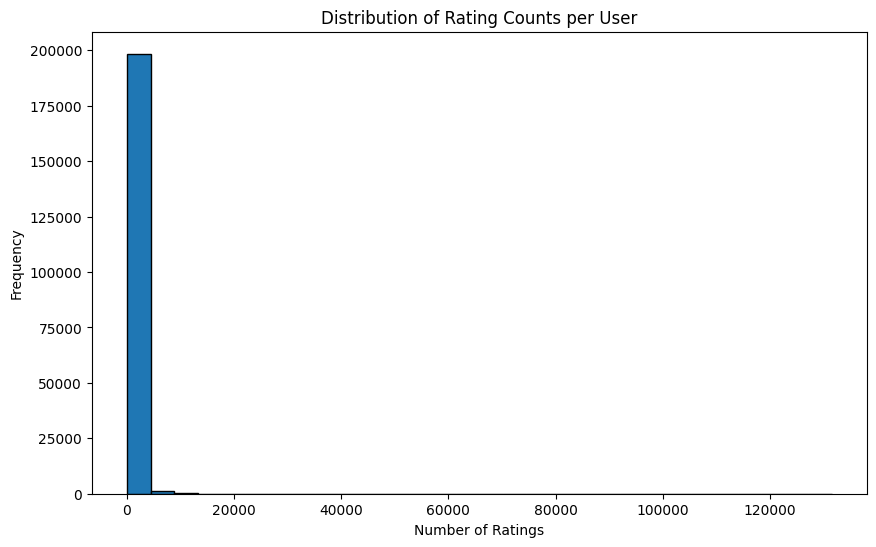

Total number of users: 200000


In [10]:
data= user_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

Use log and z-score in attempts to find outliers.

In [11]:
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  

In [12]:
mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3

In [13]:
user_ratings_count_cleaned = user_ratings_count.filter(col("is_outlier") == False)
print("User ratings dataFrame without outliers (log/z-score):", user_ratings_count_cleaned.count())

User ratings dataFrame without outliers (log/z-score): 199351


Still extremely skewed with large range of ratings count.

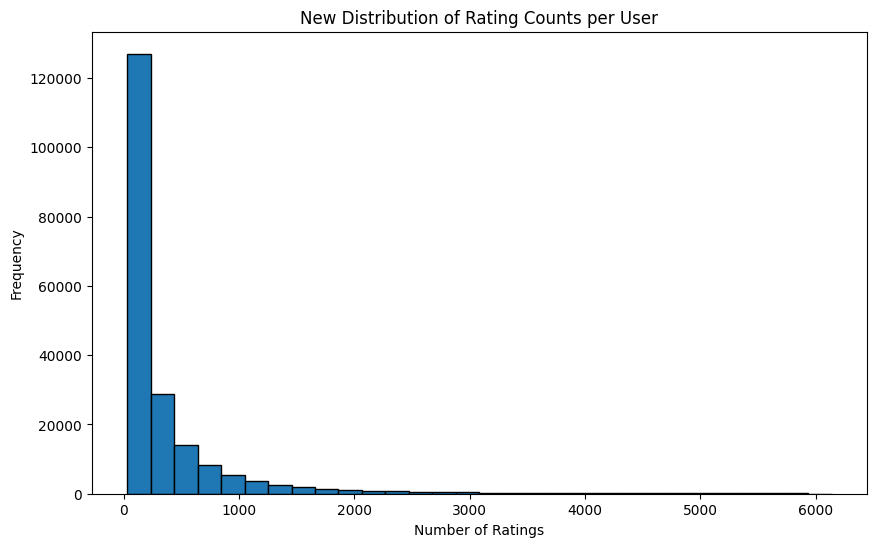

In [14]:
user_ratings_count_cleaned_data = user_ratings_count_cleaned.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count_cleaned_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [15]:
user_ratings_count_cleaned_df = df.join(user_ratings_count_cleaned.select("user_id"), on="user_id", how="inner")
user_ratings_count_cleaned_df.count() # number of ratings left

72806352

Use IQR, lower bound, upper bound to remove outliers instead

In [16]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

filtered_df = user_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))

print("User ratings dataframe without outliers (IQR/lower bound/upper bound):", filtered_df.count())

User ratings dataframe without outliers (IQR/lower bound/upper bound): 173463


Distribution a lot less skewed.

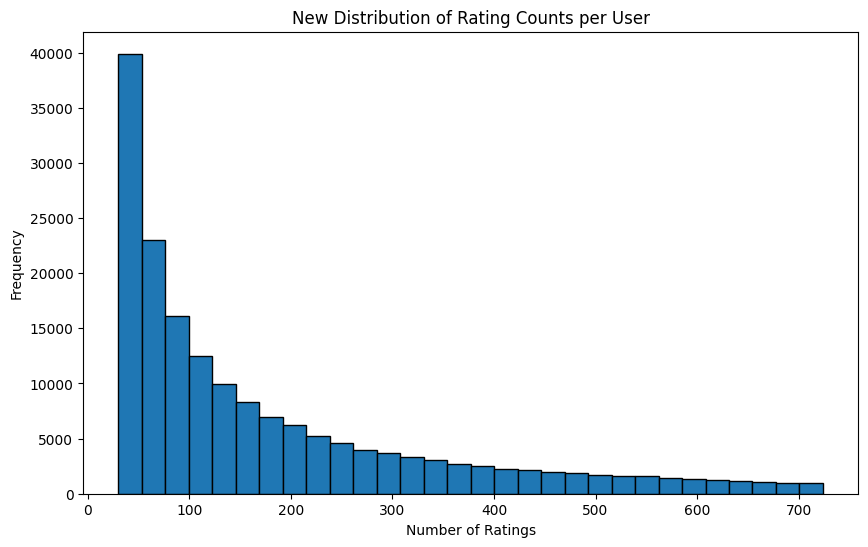

In [17]:
filtered_df_data = filtered_df.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

Filter dataframe to remove outliers and randomly split into train and test set to create model.

In [18]:
filtered_df_new = df.join(filtered_df.select("user_id"), on="user_id", how="inner")
print("New dataset count (filtered user ratings outliers)", filtered_df_new.count())

New dataset count (filtered user ratings outliers) 31116051


Balance song distribution in same manner as user distribution.

In [19]:
song_ratings_count = df.groupBy("song_id").count()
song_ratings_count = song_ratings_count.withColumnRenamed("count", "ratings_count")
song_ratings_count.show()

+-------+-------------+
|song_id|ratings_count|
+-------+-------------+
|  34759|        11156|
|  43527|          126|
|  67376|         4366|
|  67753|          390|
|  80332|         2808|
| 113000|         4553|
| 117437|         1349|
| 133524|          157|
| 126373|          925|
|   1238|         4981|
|  47084|          881|
|   4935|         2878|
|  25591|          135|
|  29601|         2290|
|  38422|          136|
|  45341|          869|
|  47711|         1125|
|  82730|         1470|
|  93341|         2060|
| 128589|          211|
+-------+-------------+
only showing top 20 rows



In [20]:
min_max_values = song_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 74
Maximum value: 36810


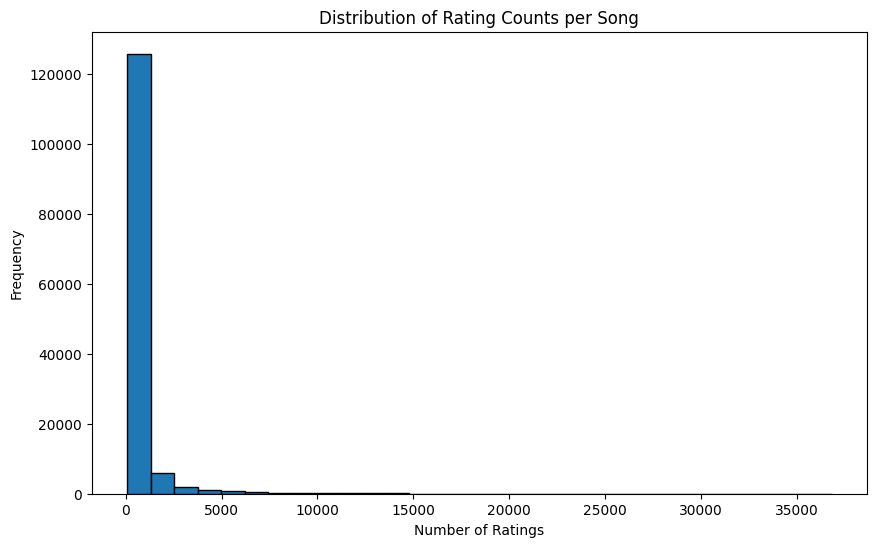

Total number of songs rated: 136736


In [21]:
data = song_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_songs = song_ratings_count.count()
print("Total number of songs rated:", total_songs)

In [22]:
quantiles = song_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

filtered_song_df = song_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))

print("Song ratings dataframe without outliers (IQR/lower bound/upper bound):", filtered_song_df.count())

Song ratings dataframe without outliers (IQR/lower bound/upper bound): 117916


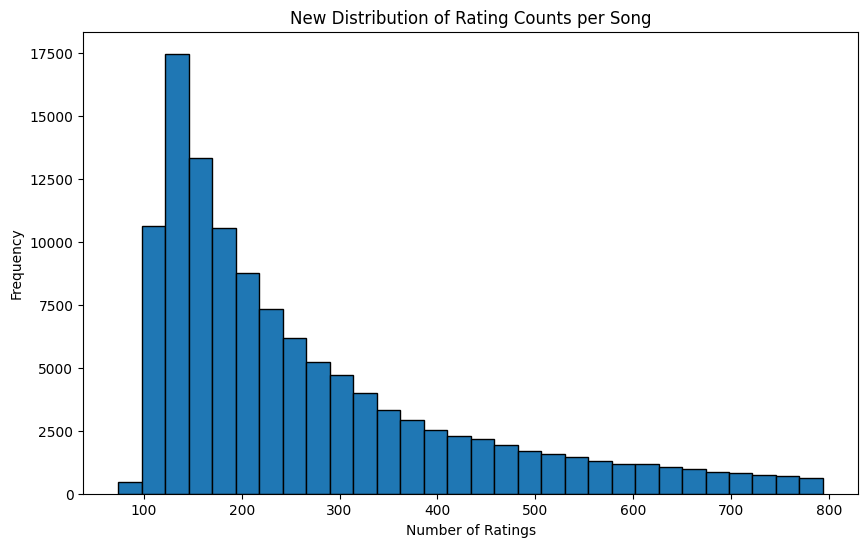

In [23]:
filtered_song_df_data = filtered_song_df.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_song_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [24]:
filtered_song_df_new = df.join(filtered_song_df.select("song_id"), on="song_id", how="inner")
print("New dataset count (filtered song ratings outliers)", filtered_song_df_new.count())

New dataset count (filtered song ratings outliers) 31500200


Filter dataset so it removes outliers of user and song ratings

In [25]:
filtered_user_final_df = df.join(filtered_df.select("user_id"), on="user_id", how="inner")
filtered_final_df = filtered_user_final_df.join(filtered_song_df.select("song_id"), on="song_id", how="inner")
print("New dataset count (filtered user & song ratings outliers)", filtered_final_df.count())

New dataset count (filtered user & song ratings outliers) 9259058


In [26]:
# Create train test split such that there is still at least 10 random ratings per user in the test set

# Shuffle the data
shuffled_df = filtered_df_new.orderBy(rand())

# Assign row numbers within each user_id partition
window = Window.partitionBy("user_id").orderBy(rand())
df = shuffled_df.withColumn("row_number", row_number().over(window))

train_df = df.filter(col("row_number") > 10)
test_df = df.filter(col("row_number") <= 10)

train_df = train_df.drop("row_number")
test_df = test_df.drop("row_number")
train_df.show(20)
test_df.show(20)
print("Train data count:", train_df.count())
print("Test data count:", test_df.count())

+-------+-------+------+--------+---------+--------+------------+
|user_id|song_id|rating|album_id|artist_id|genre_id|  genre_name|
+-------+-------+------+--------+---------+--------+------------+
| 400001|  30670|     4|    6695|     9367|       0|     Unknown|
| 400001|  94003|     4|    4661|     8187|       0|     Unknown|
| 400001|  13843|     4|    7169|     2105|       0|     Unknown|
| 400001|  39919|     5|   16811|     2105|       0|     Unknown|
| 400001|  84589|     5|    8179|     8444|       0|     Unknown|
| 400001|  18936|     5|   10268|     5068|       0|     Unknown|
| 400001|  94466|     4|   10712|     7621|       0|     Unknown|
| 400001|   3723|     5|   14162|     2020|     135|Classic Rock|
| 400001|  18663|     4|    8240|     3065|       0|     Unknown|
| 400001| 105499|     4|   10633|     8673|       0|     Unknown|
| 400001|  41073|     4|    3334|      868|       0|     Unknown|
| 400001| 121369|     5|   14800|      770|       0|     Unknown|
| 400001| 

+-------+-------+------+--------+---------+--------+------------+
|user_id|song_id|rating|album_id|artist_id|genre_id|  genre_name|
+-------+-------+------+--------+---------+--------+------------+
| 400001|  94466|     4|   10712|     7621|       0|     Unknown|
| 400001| 114356|     4|   17519|       69|     134|        Rock|
| 400001|  83028|     5|    7194|     7676|       0|     Unknown|
| 400001| 121369|     5|   14800|      770|       0|     Unknown|
| 400001| 117092|     5|   10335|     5958|       0|     Unknown|
| 400001|  66132|     5|    5618|     8444|       0|     Unknown|
| 400001|   3723|     5|   14162|     2020|     135|Classic Rock|
| 400001|  90136|     4|    6176|     3371|       0|     Unknown|
| 400001|  39919|     5|   16811|     2105|       0|     Unknown|
| 400001| 136062|     4|    9357|     8638|       0|     Unknown|
| 400003|  90171|     2|   11871|     8359|       0|     Unknown|
| 400003|  44145|     5|    9280|      312|       0|     Unknown|
| 400003| 

Train data count: 29381421


Test data count: 1734630


In [27]:
# Make dirs if not exist
!mkdir -p $TRAIN_DIR
!mkdir -p $TEST_DIR

# Save Train to local
train_df = train_df.coalesce(1)
test_df = test_df.coalesce(1)
train_df.write.csv(f"file://{TRAIN_DIR}/temp", header=False, mode="overwrite", sep="\t")
test_df.write.csv(f"file://{TEST_DIR}/temp", header=False, mode="overwrite", sep="\t")

In [28]:
# Move to single file
! rm -rf $TRAIN_DIR/train_0.txt
! mv $TRAIN_DIR/temp/part-00000* $TRAIN_DIR/train_0.txt
! rm -rf $TEST_DIR/test_0.txt
! mv $TEST_DIR/temp/part-00000* $TEST_DIR/test_0.txt

# Clean up
! rm -rf $TRAIN_DIR/temp
! rm -rf $TEST_DIR/temp